<a href="https://colab.research.google.com/github/jbdenniso/NeuroMatch22/blob/main/Copy_of_VideoResnet_GroupNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

Test text display

# Algonauts2021 dataset


Here we will load fMRI responses (whole brain + 9 ROIs) to 1000 video clips of 3 seconds and visualize in glass brain using nilearn.

**P.S.** The dataset provided is part of Algonauts 2021 Challenge. Please check the details [here](http://algonauts.csail.mit.edu/challenge.html) if you are interested in participating. 

In [ ]:
!pip install fvcore
!pip install pytorchvideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 9.6 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=a3b07977d3ce620b99186c48828ecb7b96ae6c3e7b8c56baa751b0a0314ba836
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=f47eb2f63ea21fa6509d3ba5ccb0c84a9a4fdb4eaa56a8ad057abb3ef4664392
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: ht

In [ ]:
# @title Installations
!pip install nilearn
!pip install decord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 4.9 MB/s 


In [ ]:
# Imports from load_algonauts NMA notebook
import os
import cv2
import glob
import time
import torch
import random
import urllib
import pickle
import argparse

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable as V
from torchvision import transforms as trn
from torchvision.transforms._presets import VideoClassification

from nilearn import surface
from nilearn import datasets
from nilearn import plotting

from decord import cpu
from decord import VideoReader


#From Algonauts2021 baseline notebook
from tqdm import tqdm
from torch.autograd import Variable as V
import torch.nn.functional as F

from functools import partial
from typing import Tuple, Optional, Callable, List, Sequence, Type, Any, Union

#from resnet
from torch import Tensor
import tensorflow as tf

from torchvision.utils import _log_api_usage_once
from torchvision.models._api import WeightsEnum, Weights
from torchvision.models._meta import _KINETICS400_CATEGORIES
from torchvision.models._utils import handle_legacy_interface, _ovewrite_named_param


fsaverage = datasets.fetch_surf_fsaverage()


Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9). 

**Important:** You MUST set `dropbox_link` parameter `dl=1`, e.g., `https://www.dropbox.com/myurl/participants_data.zip?dl=1`

In [ ]:
# @title Enter the dropbox link and run the cell
#dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1'  # @param {type:"string"}

In [ ]:
#@title Enter the download link and run the cell
dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["dropbox_link"] = dropbox_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt


wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
unzip:  cannot find or open participants_data.zip, participants_data.zip.zip or participants_data.zip.ZIP.
--2022-07-28 13:42:57--  https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/example.nii [following]
--2022-07-28 13:42:57--  https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/example.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request

In [ ]:
# @title Run the cell to download the data

import requests, zipfile, io

# Use the dropbox link to download the data

if dropbox_link:
  fname1 = 'participants_data_v2021'
  fname2 = 'AlgonautsVideos268_All_30fpsmax'
  if not os.path.exists(fname1) or not os.path.exists(fname2):
    print('Data downloading...')
    r = requests.get(dropbox_link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print('Data download is completed.')
  else:
    print('Data are already downloaded.')


  url = 'https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii'
  fname = 'example.nii'
  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
  else:
    print(f"{fname} file is already downloaded.")

else:
  print('You need to submit the form and get the dropbox link')

Data downloading...
Data download is completed.
example.nii file is already downloaded.


#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge. 

In the first track, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.
 

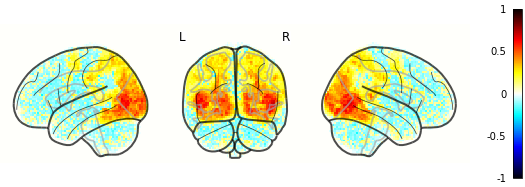

In the second track, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


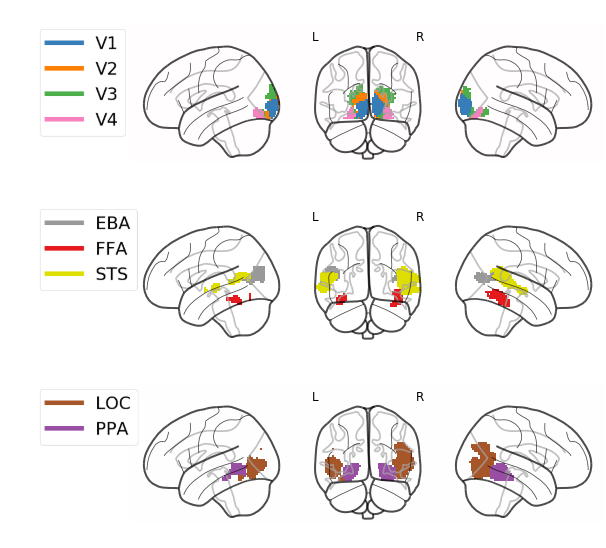

#Loading fMRI data
The dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [ ]:
# @title Utility functions for data loading
def save_dict(di_, filename_):
  with open(filename_, 'wb') as f:
    pickle.dump(di_, f)


def load_dict(filename_):
  with open(filename_, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    ret_di = u.load()
    # print(p)
    # ret_di = pickle.load(f)
  return ret_di


def visualize_activity(vid_id, sub):
  # Setting up the paths for whole brain data
  fmri_dir = './participants_data_v2021'
  track ='full_track'

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)

  # get the selected subject's directory
  sub_fmri_dir = os.path.join(track_dir, sub)

  # result directory to store nifti file
  results_dir = '/content/'

  # mapping the data to voxels and storing in a nifti file
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir, "WB")
  visual_mask_3D = np.zeros((78, 93, 71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id, :]
  brain_mask = './example.nii'
  nii_save_path = os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask, nii_save_path, visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)


def get_fmri(fmri_dir, ROI):
  """This function loads fMRI data into a numpy array for to a given ROI.
  Parameters
  ----------
  fmri_dir : str
    path to fMRI data.
  ROI : str
    name of ROI.
  Returns
  -------
  np.array
    matrix of dimensions #train_vids x #repetitions x #voxels
    containing fMRI responses to train videos of a given ROI
  """
  # Loading ROI data
  ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
  ROI_data = load_dict(ROI_file)
  # averaging ROI data across repetitions
  ROI_data_train = np.mean(ROI_data["train"], axis=1)
  if ROI == "WB":
    voxel_mask = ROI_data['voxel_mask']
    return ROI_data_train, voxel_mask

  return ROI_data_train


def saveasnii(brain_mask, nii_save_path, nii_data):
  img = nib.load(brain_mask)
  nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
  nib.save(nii_img, nii_save_path)

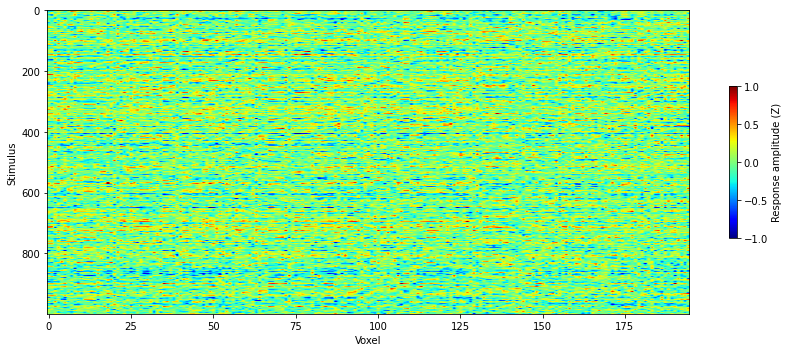

In [ ]:
# @title Loading fMRI data and inspecting dimensions
# Select Subject
sub = 'sub07'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

# Select ROI
ROI = 'V1'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = './participants_data_v2021'
if ROI == "WB":  # Loading whole brain data
  track = "full_track"  # stored in full_track directory
else:  # Loading ROI data
  track = "mini_track" # stored in mini_track directory

# get the right track directory depending on whole brain/ROI choice
track_dir = os.path.join(fmri_dir, track)

# get the selected subject's directory
sub_fmri_dir = os.path.join(track_dir, sub)

# Load the fMRI data for the selected subject and ROI
if track == "full_track":
  fmri_train_all,_ = get_fmri(sub_fmri_dir,ROI)
else:
  fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################

# Visualize the fMRI responses in a heatmap
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto", cmap='jet', vmin=-1, vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI responses were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html). 

Visualize a given video (with id from 0-999)) and its corresponding brain activity

In [ ]:
# @title Visualize video
from IPython.display import HTML
from base64 import b64encode

vid_id =   16# @param {type: "integer"}
video_dir = './AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

mp4 = open(video_list[vid_id], 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

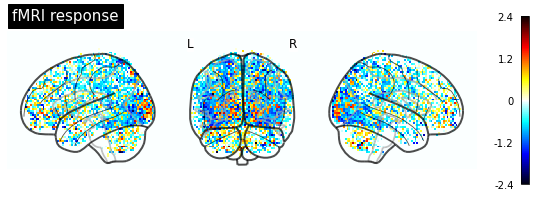

In [ ]:
# @title Visualize corresponding brain response
visualize_activity(vid_id, sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

In [ ]:
#@title ResNet Models
__all__ = [
    "VideoResNet",
    "R3D_18_Weights",
    "MC3_18_Weights",
    "R2Plus1D_18_Weights",
    "r3d_18",
    "mc3_18",
    "r2plus1d_18",
]


class Conv3DSimple(nn.Conv3d):
    def __init__(
        self, in_planes: int, out_planes: int, midplanes: Optional[int] = None, stride: int = 1, padding: int = 1
    ) -> None:

        super().__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(3, 3, 3),
            stride=stride,
            padding=padding,
            bias=False,
        )

    @staticmethod
    def get_downsample_stride(stride: int) -> Tuple[int, int, int]:
        return stride, stride, stride


class Conv2Plus1D(nn.Sequential):
    def __init__(self, in_planes: int, out_planes: int, midplanes: int, stride: int = 1, padding: int = 1) -> None:
        super().__init__(
            nn.Conv3d(
                in_planes,
                midplanes,
                kernel_size=(1, 3, 3),
                stride=(1, stride, stride),
                padding=(0, padding, padding),
                bias=False,
            ),
            nn.BatchNorm3d(midplanes),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                midplanes, out_planes, kernel_size=(3, 1, 1), stride=(stride, 1, 1), padding=(padding, 0, 0), bias=False
            ),
        )

    @staticmethod
    def get_downsample_stride(stride: int) -> Tuple[int, int, int]:
        return stride, stride, stride


class Conv3DNoTemporal(nn.Conv3d):
    def __init__(
        self, in_planes: int, out_planes: int, midplanes: Optional[int] = None, stride: int = 1, padding: int = 1
    ) -> None:

        super().__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(1, 3, 3),
            stride=(1, stride, stride),
            padding=(0, padding, padding),
            bias=False,
        )

    @staticmethod
    def get_downsample_stride(stride: int) -> Tuple[int, int, int]:
        return 1, stride, stride


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        conv_builder: Callable[..., nn.Module],
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
    ) -> None:
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        super().__init__()
        self.conv1 = nn.Sequential(
            conv_builder(inplanes, planes, midplanes, stride), nn.BatchNorm3d(planes), nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(conv_builder(planes, planes, midplanes), nn.BatchNorm3d(planes))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        conv_builder: Callable[..., nn.Module],
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
    ) -> None:

        super().__init__()
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        # 1x1x1
        self.conv1 = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=1, bias=False), nn.BatchNorm3d(planes), nn.ReLU(inplace=True)
        )
        # Second kernel
        self.conv2 = nn.Sequential(
            conv_builder(planes, planes, midplanes, stride), nn.BatchNorm3d(planes), nn.ReLU(inplace=True)
        )

        # 1x1x1
        self.conv3 = nn.Sequential(
            nn.Conv3d(planes, planes * self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm3d(planes * self.expansion),
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class BasicStem(nn.Sequential):
    """The default conv-batchnorm-relu stem"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )


class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )


class VideoResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        num_classes: int = 400,
        zero_init_residual: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()
        _log_api_usage_once(self)
        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def forward(self, x: Tensor) -> Tensor:
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # Flatten the layer to fc
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)


def _video_resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
    layers: List[int],
    stem: Callable[..., nn.Module],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> VideoResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = VideoResNet(block, conv_makers, layers, stem, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model


_COMMON_META = {
    "min_size": (1, 1),
    "categories": _KINETICS400_CATEGORIES,
    "recipe": "https://github.com/pytorch/vision/tree/main/references/video_classification",
    "_docs": (
        "The weights reproduce closely the accuracy of the paper. The accuracies are estimated on video-level "
        "with parameters `frame_rate=15`, `clips_per_video=5`, and `clip_len=16`."
    ),
}


class R3D_18_Weights(WeightsEnum):
    KINETICS400_V1 = Weights(
        url="https://download.pytorch.org/models/r3d_18-b3b3357e.pth",
        transforms=partial(VideoClassification, crop_size=(112, 112), resize_size=(128, 171)),
        meta={
            **_COMMON_META,
            "num_params": 33371472,
            "_metrics": {
                "Kinetics-400": {
                    "acc@1": 63.200,
                    "acc@5": 83.479,
                }
            },
        },
    )
    DEFAULT = KINETICS400_V1


class MC3_18_Weights(WeightsEnum):
    KINETICS400_V1 = Weights(
        url="https://download.pytorch.org/models/mc3_18-a90a0ba3.pth",
        transforms=partial(VideoClassification, crop_size=(112, 112), resize_size=(128, 171)),
        meta={
            **_COMMON_META,
            "num_params": 11695440,
            "_metrics": {
                "Kinetics-400": {
                    "acc@1": 63.960,
                    "acc@5": 84.130,
                }
            },
        },
    )
    DEFAULT = KINETICS400_V1


class R2Plus1D_18_Weights(WeightsEnum):
    KINETICS400_V1 = Weights(
        url="https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth",
        transforms=partial(VideoClassification, crop_size=(112, 112), resize_size=(128, 171)),
        meta={
            **_COMMON_META,
            "num_params": 31505325,
            "_metrics": {
                "Kinetics-400": {
                    "acc@1": 67.463,
                    "acc@5": 86.175,
                }
            },
        },
    )
    DEFAULT = KINETICS400_V1


@handle_legacy_interface(weights=("pretrained", R3D_18_Weights.KINETICS400_V1))
def r3d_18(*, weights: Optional[R3D_18_Weights] = None, progress: bool = True, **kwargs: Any) -> VideoResNet:
    """Construct 18 layer Resnet3D model.

    .. betastatus:: video module

    Reference: `A Closer Look at Spatiotemporal Convolutions for Action Recognition <https://arxiv.org/abs/1711.11248>`__.

    Args:
        weights (:class:`~torchvision.models.video.R3D_18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.video.R3D_18_Weights`
            below for more details, and possible values. By default, no
            pre-trained weights are used.
        progress (bool): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.video.resnet.VideoResNet`` base class.
            Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/video/resnet.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.video.R3D_18_Weights
        :members:
    """
    weights = R3D_18_Weights.verify(weights)

    return _video_resnet(
        BasicBlock,
        [Conv3DSimple] * 4,
        [2, 2, 2, 2],
        BasicStem,
        weights,
        progress,
        **kwargs,
    )


@handle_legacy_interface(weights=("pretrained", MC3_18_Weights.KINETICS400_V1))
def mc3_18(*, weights: Optional[MC3_18_Weights] = None, progress: bool = True, **kwargs: Any) -> VideoResNet:
    """Construct 18 layer Mixed Convolution network as in

    .. betastatus:: video module

    Reference: `A Closer Look at Spatiotemporal Convolutions for Action Recognition <https://arxiv.org/abs/1711.11248>`__.

    Args:
        weights (:class:`~torchvision.models.video.MC3_18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.video.MC3_18_Weights`
            below for more details, and possible values. By default, no
            pre-trained weights are used.
        progress (bool): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.video.resnet.VideoResNet`` base class.
            Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/video/resnet.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.video.MC3_18_Weights
        :members:
    """
    weights = MC3_18_Weights.verify(weights)

    return _video_resnet(
        BasicBlock,
        [Conv3DSimple] + [Conv3DNoTemporal] * 3,  # type: ignore[list-item]
        [2, 2, 2, 2],
        BasicStem,
        weights,
        progress,
        **kwargs,
    )


@handle_legacy_interface(weights=("pretrained", R2Plus1D_18_Weights.KINETICS400_V1))
def r2plus1d_18(*, weights: Optional[R2Plus1D_18_Weights] = None, progress: bool = True, **kwargs: Any) -> VideoResNet:
    """Construct 18 layer deep R(2+1)D network as in

    .. betastatus:: video module

    Reference: `A Closer Look at Spatiotemporal Convolutions for Action Recognition <https://arxiv.org/abs/1711.11248>`__.

    Args:
        weights (:class:`~torchvision.models.video.R2Plus1D_18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.video.R2Plus1D_18_Weights`
            below for more details, and possible values. By default, no
            pre-trained weights are used.
        progress (bool): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.video.resnet.VideoResNet`` base class.
            Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/video/resnet.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.video.R2Plus1D_18_Weights
        :members:
    """
    weights = R2Plus1D_18_Weights.verify(weights)

    return _video_resnet(
        BasicBlock,
        [Conv2Plus1D] * 4,
        [2, 2, 2, 2],
        R2Plus1dStem,
        weights,
        progress,
        **kwargs,
    )


# The dictionary below is internal implementation detail and will be removed in v0.15
from torchvision.models._utils import _ModelURLs


model_urls = _ModelURLs(
    {
        "r3d_18": R3D_18_Weights.KINETICS400_V1.url,
        "mc3_18": MC3_18_Weights.KINETICS400_V1.url,
        "r2plus1d_18": R2Plus1D_18_Weights.KINETICS400_V1.url,
    }
)

In [ ]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

model =  torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
 #first time defining model

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates define model features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : define.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """ 
    save_dir = "/content/activations_resnet_threshold"
    activations_dir = os.path.join(save_dir)
    #os.mkdir(activations_dir)
    features={}
    import collections

    for clip in video_list:
      print(clip)
      if clip != '/content/AlgonautsVideos268_All_30fpsmax/0359_flickr-1-6-2-3-0-0-5-1-5016230051_8.mp4' and clip != '/content/AlgonautsVideos268_All_30fpsmax/0832_flickr-7-9-6-9-8-4-3-7-6279698437_3.mp4':
        # Select the duration of the clip to load by specifying the start and end duration
        # The start_sec should correspond to where the action occurs in the video
        start_sec = 0
        #end_sec = start_sec + clip_duration

        # Initialize an EncodedVideo helper class and load the video
        video = EncodedVideo.from_path(clip)

        # Load the desired clip
        video_data = video.get_clip(start_sec=start_sec, end_sec=3)

        # Define input transform
        side_size = 256
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        crop_size = 256
        num_frames = 8
        sampling_rate = 8
        frames_per_second = 30

        # Note that this transform is specific to the slow_R50 model.
        transform =  ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames),
                    Lambda(lambda x: x/255.0),
                    NormalizeVideo(mean, std),
                    ShortSideScale(
                        size=side_size
                    ),
                    CenterCropVideo(crop_size=(crop_size, crop_size))
                ]
            ),
        )
         # The duration of the input clip is also specific to the model.
        clip_duration = (num_frames * sampling_rate)/frames_per_second

        #added this to see if this will make videos smaller


        # Apply a transform to normalize the video input
        video_data = transform(video_data)

        # Move the inputs to the desired device
        inputs = video_data["video"]
  #        inputs = inputs.to(device)

        # Pass the input clip through the model
        preds = model(inputs[None, ...])
        pred_class_names = [kinetics_id_to_classname[int(i)] for i in kinetics_id_to_classname]
        
        threshold=30
        # sort the probability vector in descending order
        sorted, indices = torch.sort(preds, descending=True)
        percentage = F.softmax(preds, dim=1)[0] * 100.0
        # obtain the first 5 classes (with the highest probability) the input belongs to
        results = [(pred_class_names[i], percentage[i].item()) for i in indices[0][:5]]
        keep=False
        for i in range(5):
            print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
        if results[0][1] >= threshold:
          keep=True
        else:
          keep=False
        #print(results[0][1])
        return keep, results[0][1]

        if keep==True:
          output.append(results) 
          #this is where I am lost, what should I append and keep?

        activation = {}    
        def get_activation(name):
          def hook(model, input, output):
            activation[name] = output.detach()
          return hook

        #activations=[]
        for layer in [n for n, _ in model.blocks.named_children()]:
          model.blocks[int(layer)].register_forward_hook(get_activation('%s'%(layer)))
          output = model(inputs[None, ...])
          if layer == str(5):
            avg_layer_activation = activation['%s'%(layer)].numpy().ravel()
          else:
            a = torch.mean(activation['%s'%(layer)], dim=2)
            avg_layer_activation = a.numpy().ravel()
          save_path = os.path.join(activations_dir, clip[41:-4]+"_"+"layer" + "_" + str(int(layer)+1) + ".npy")
          np.save(save_path,avg_layer_activation)


def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_6'] #,'layer_2','layer_3','layer_4','layer_5', 'layer_6']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:998,:]
        x_test = x[998:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOW_8x8_R50.pyth


  0%|          | 0.00/248M [00:00<?, ?B/s]

In [ ]:
#@title 3D ResNet Model Prediction
# Choose the `slow_r50` model 
#model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
#here we should just be abe to change any of the above ResNet models
model = model

# Import necessary tranformations
import pytorchvideo
import av
import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

# Download the id to label mapping for the Kinetics 400 dataset on which the torch hub models were trained. 
# This will be used to get the category label names from the predicted class ids.
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

# Define input transform
#side_size = 256
#mean = [0.45, 0.45, 0.45]
#std = [0.225, 0.225, 0.225]
#crop_size = 256
#num_frames = 8
#sampling_rate = 8
#frames_per_second = 30

# Note that this transform is specific to the slow_R50 model.
#transform =  ApplyTransformToKey(
    #key="video",
    #transform=Compose(
 #       [
 #           UniformTemporalSubsample(num_frames),
 #           Lambda(lambda x: x/255.0),
  #          NormalizeVideo(mean, std),
  #          ShortSideScale(
  #              size=side_size
            #),
            #CenterCropVideo(crop_size=(crop_size, crop_size))
        #]
    #),
#)

# The duration of the input clip is also specific to the model.
#clip_duration = (num_frames * sampling_rate)/frames_per_second


# Run Inference
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
save_dir = "/content/activations_resnet_threshold"
activations_dir = os.path.join(save_dir)

# Map the predicted classes to the label names
get_activations_and_save(model=model, video_list=video_list,activations_dir=activations_dir)

/content/AlgonautsVideos268_All_30fpsmax/1045_flickr-3-9-0-1-2-9-0-4-5139012904_4.mp4
tango dancing: 27.9896%
climbing ladder: 4.6400%
blowing leaves: 3.0468%
front raises: 2.3652%
taking a shower: 2.2495%
/content/AlgonautsVideos268_All_30fpsmax/0180_8-8-1-8014192881.mp4
peeling potatoes: 5.7076%
salsa dancing: 5.0146%
recording music: 3.3224%
dancing ballet: 2.7543%
playing trombone: 2.5396%


KeyboardInterrupt: ignored

In [ ]:
#@title Defining save path/video directory
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
save_dir = "/content/activations_resnet"
activations_dir = os.path.join(save_dir)

In [ ]:
print(len(video_list))
x = get_fmri('participants_data_v2021/mini_track/sub10', 'EBA')
print(x.shape)

1102
(1000, 162)


In [ ]:
#@title Running PCA
# preprocessing using PCA and save : CHANGE THIS CELL TO IMPLEMENT DIFFERENT DIM REDUCTION METHODS
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
do_PCA_and_save(activations_dir, pca_dir)

-------------performing  PCA----------------------------


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


In [ ]:
#VOXEL-WISE ENCODING!

In [ ]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky = torch.linalg.solve(XtX, Xty)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

In [ ]:
#@title Functions for fmri predictions
def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations



def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/activations_resnet'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  print(fmri_train_all.shape)
  fmri_train_all = np.delete(fmri_train_all,[358,831],axis=0)
  print(fmri_train_all.shape)
  ######################################

# videos to delete 0359 and 0832
  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 100
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)
  return (ROI,sub,layer,score)
  



(1000, 18222)
(998, 18222)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub01  using  layer_1  is : 0.022887
(1000, 18222)
(998, 18222)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub01  using  layer_3  is : 0.041426
(1000, 18222)
(998, 18222)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub01  using  layer_4  is : 0.102775
(1000, 18222)
(998, 18222)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub01  using  layer_5  is : 0.097566
(1000, 18222)
(998, 18222)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub01  using  layer_6  is : 0.088945
(1000, 232)
(998, 232)
----------------------------------------------------------------------------
Mean correlation for

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 13340)
(998, 13340)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub05  using  layer_3  is : 0.06589


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 13340)
(998, 13340)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub05  using  layer_4  is : 0.119442


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 13340)
(998, 13340)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub05  using  layer_5  is : 0.109566


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 13340)
(998, 13340)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub05  using  layer_6  is : 0.094648


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 326)
(998, 326)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub05  using  layer_1  is : 0.240391
(1000, 326)
(998, 326)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub05  using  layer_3  is : 0.270914
(1000, 326)
(998, 326)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub05  using  layer_4  is : 0.341268
(1000, 326)
(998, 326)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub05  using  layer_5  is : 0.265401
(1000, 326)
(998, 326)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub05  using  layer_6  is : 0.226447
(1000, 196)
(998, 196)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub05

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 19818)
(998, 19818)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub06  using  layer_3  is : 0.037415


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 19818)
(998, 19818)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub06  using  layer_4  is : 0.070373


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 19818)
(998, 19818)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub06  using  layer_5  is : 0.073805


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 19818)
(998, 19818)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub06  using  layer_6  is : 0.074859


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 286)
(998, 286)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub06  using  layer_1  is : 0.192092
(1000, 286)
(998, 286)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub06  using  layer_3  is : 0.202111
(1000, 286)
(998, 286)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub06  using  layer_4  is : 0.247146
(1000, 286)
(998, 286)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub06  using  layer_5  is : 0.213154
(1000, 286)
(998, 286)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub06  using  layer_6  is : 0.148684
(1000, 281)
(998, 281)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub06

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 10836)
(998, 10836)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub07  using  layer_3  is : 0.028622


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 10836)
(998, 10836)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub07  using  layer_4  is : 0.051103


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 10836)
(998, 10836)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub07  using  layer_5  is : 0.062179


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 10836)
(998, 10836)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub07  using  layer_6  is : 0.042791


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 195)
(998, 195)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub07  using  layer_1  is : 0.103108
(1000, 195)
(998, 195)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub07  using  layer_3  is : 0.118019
(1000, 195)
(998, 195)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub07  using  layer_4  is : 0.146978
(1000, 195)
(998, 195)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub07  using  layer_5  is : 0.137926
(1000, 195)
(998, 195)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub07  using  layer_6  is : 0.073825
(1000, 189)
(998, 189)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub07

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12347)
(998, 12347)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub08  using  layer_3  is : 0.026396


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12347)
(998, 12347)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub08  using  layer_4  is : 0.107109


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12347)
(998, 12347)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub08  using  layer_5  is : 0.096745


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12347)
(998, 12347)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub08  using  layer_6  is : 0.104204


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 300)
(998, 300)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub08  using  layer_1  is : 0.201807
(1000, 300)
(998, 300)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub08  using  layer_3  is : 0.192548
(1000, 300)
(998, 300)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub08  using  layer_4  is : 0.245359
(1000, 300)
(998, 300)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub08  using  layer_5  is : 0.19836
(1000, 300)
(998, 300)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub08  using  layer_6  is : 0.155169
(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub08 

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 17570)
(998, 17570)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub09  using  layer_3  is : 0.040549


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 17570)
(998, 17570)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub09  using  layer_4  is : 0.106373


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 17570)
(998, 17570)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub09  using  layer_5  is : 0.092487


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 17570)
(998, 17570)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub09  using  layer_6  is : 0.092894


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 271)
(998, 271)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub09  using  layer_1  is : 0.173889
(1000, 271)
(998, 271)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub09  using  layer_3  is : 0.161771
(1000, 271)
(998, 271)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub09  using  layer_4  is : 0.204168
(1000, 271)
(998, 271)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub09  using  layer_5  is : 0.135804
(1000, 271)
(998, 271)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub09  using  layer_6  is : 0.128739
(1000, 265)
(998, 265)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub09

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12950)
(998, 12950)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub10  using  layer_3  is : 0.044079


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12950)
(998, 12950)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub10  using  layer_4  is : 0.11311


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12950)
(998, 12950)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub10  using  layer_5  is : 0.108562


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 12950)
(998, 12950)
----------------------------------------------------------------------------
Mean correlation for ROI :  WB in  sub10  using  layer_6  is : 0.090869


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub10  using  layer_1  is : 0.265741
(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub10  using  layer_3  is : 0.245225
(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub10  using  layer_4  is : 0.337774
(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub10  using  layer_5  is : 0.264135
(1000, 238)
(998, 238)
----------------------------------------------------------------------------
Mean correlation for ROI :  V1 in  sub10  using  layer_6  is : 0.225391
(1000, 249)
(998, 249)
----------------------------------------------------------------------------
Mean correlation for ROI :  V2 in  sub10

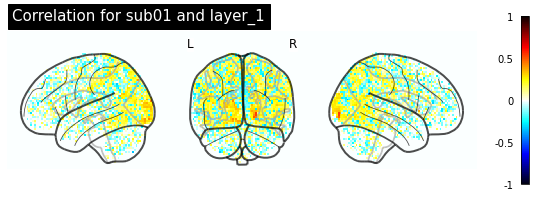

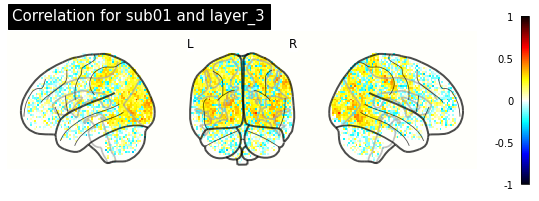

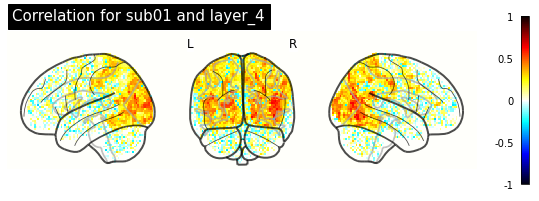

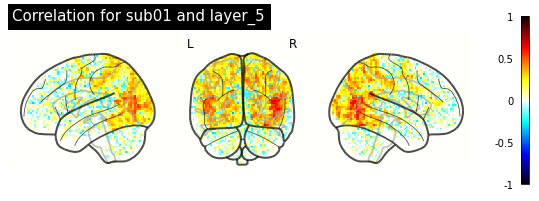

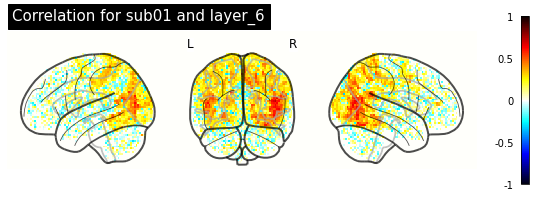

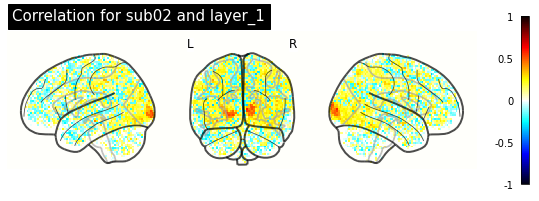

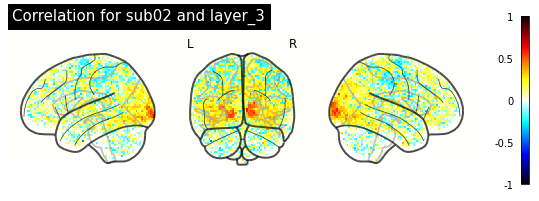

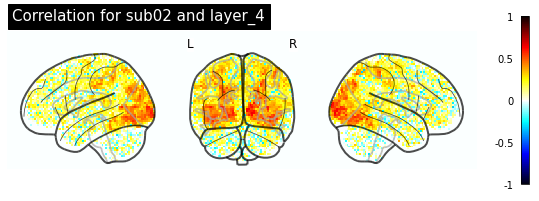

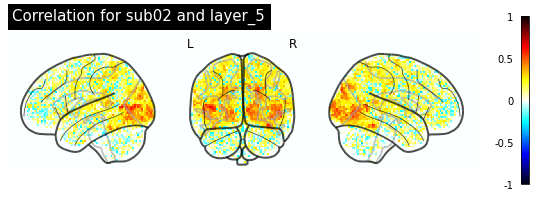

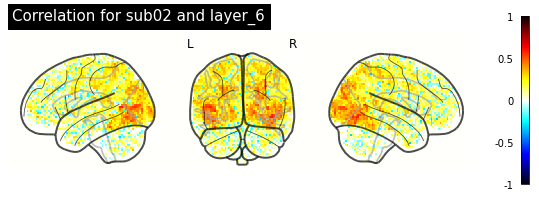

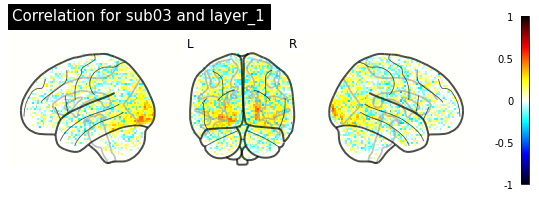

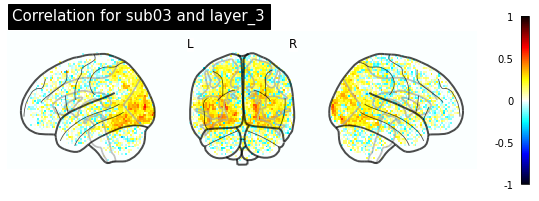

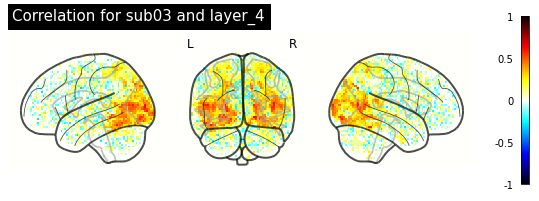

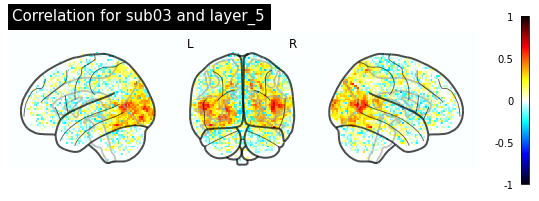

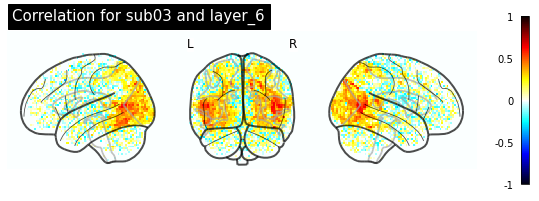

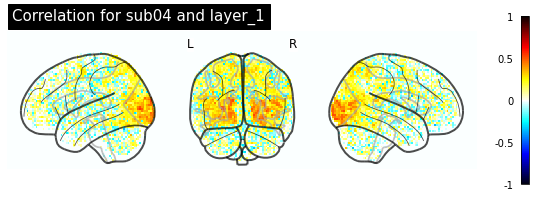

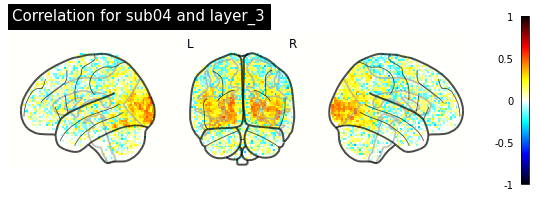

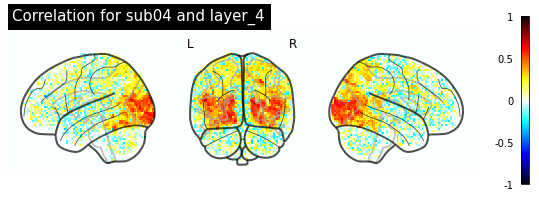

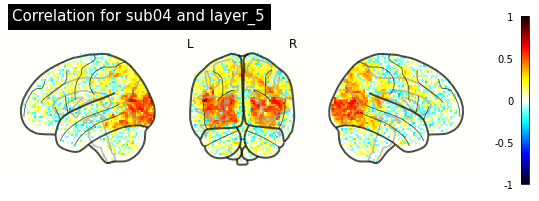

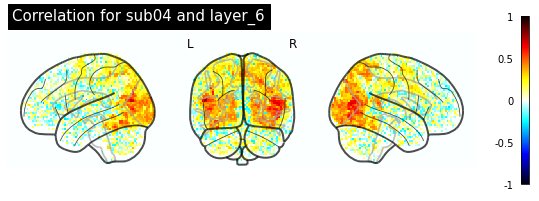

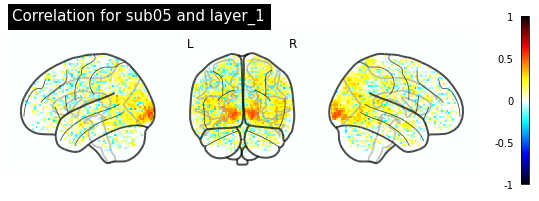

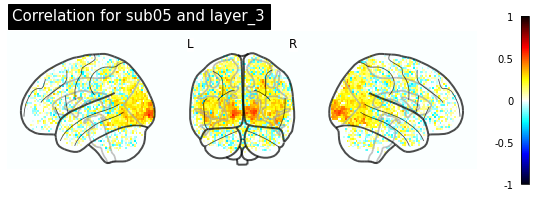

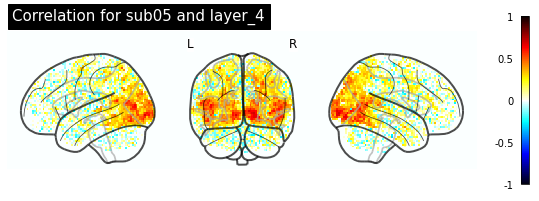

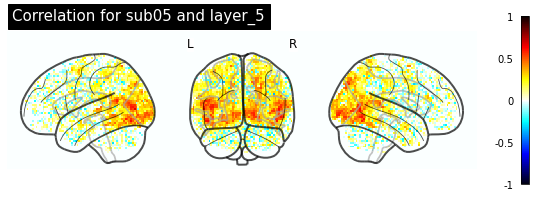

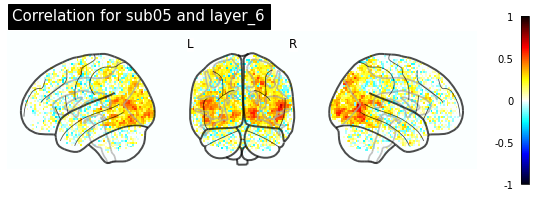

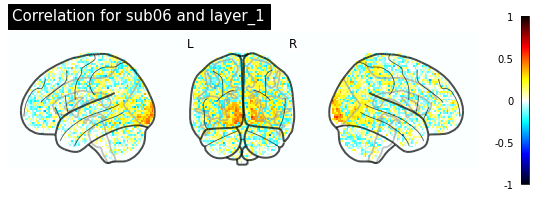

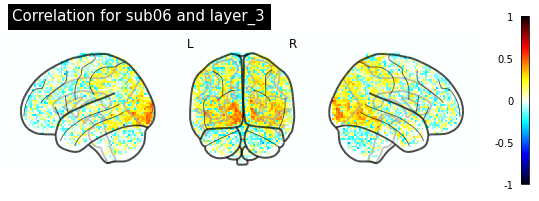

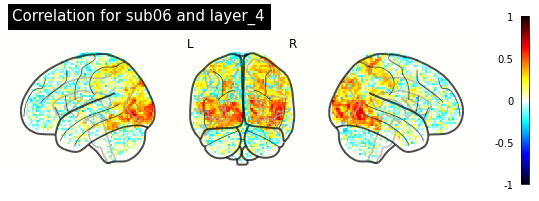

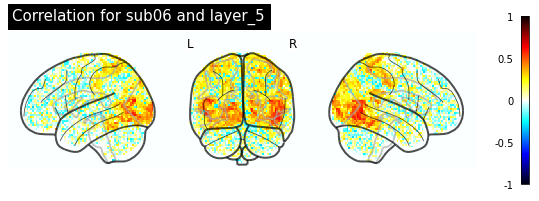

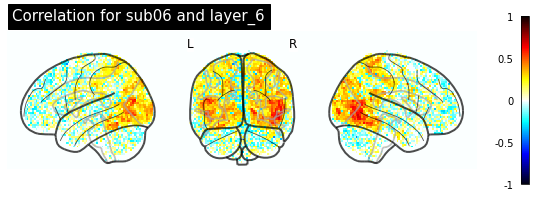

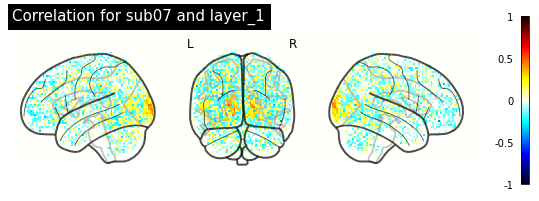

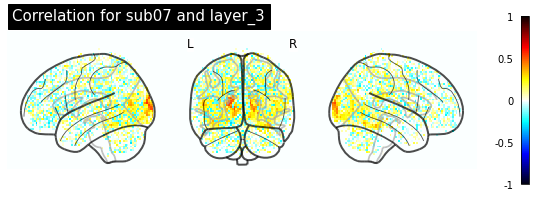

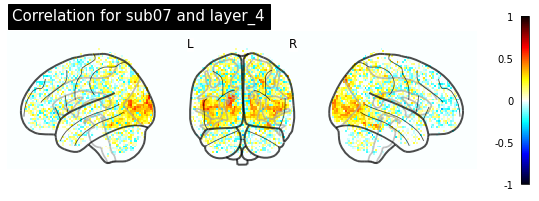

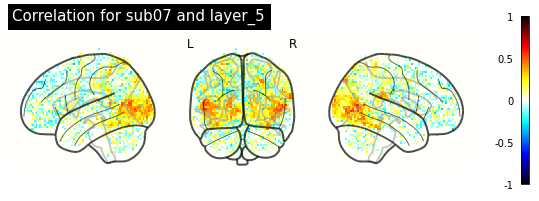

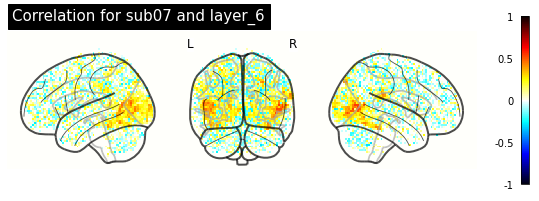

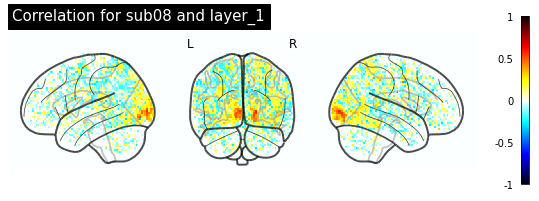

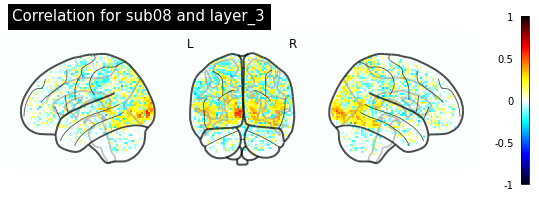

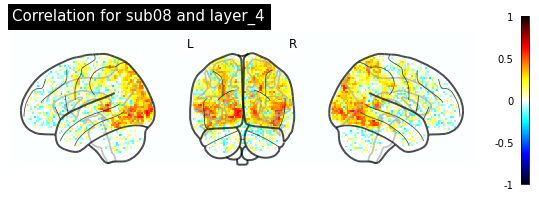

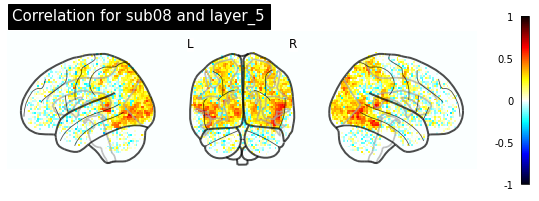

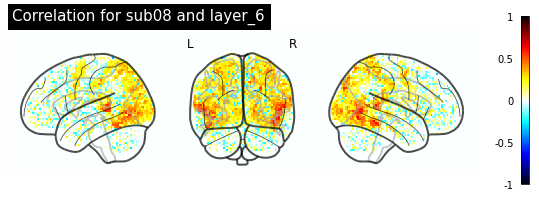

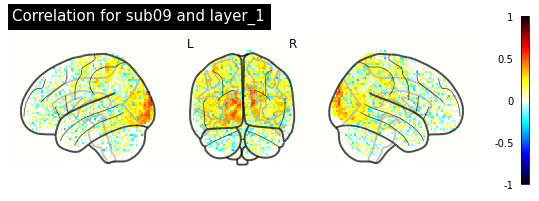

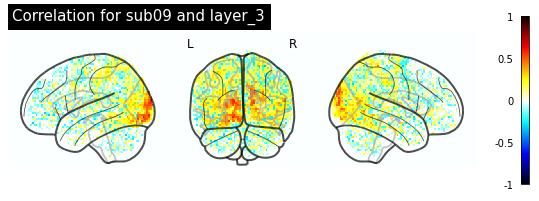

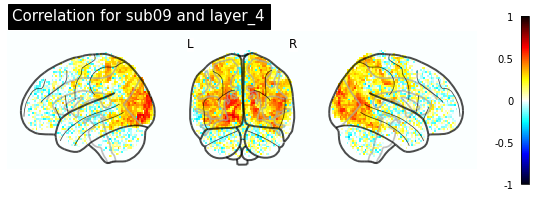

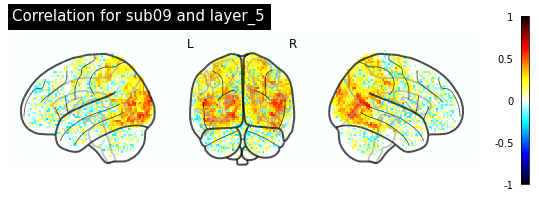

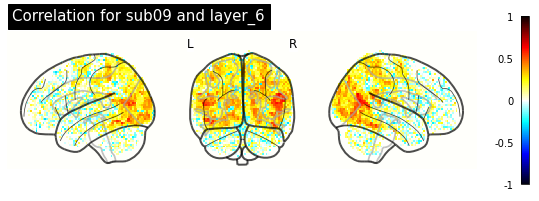

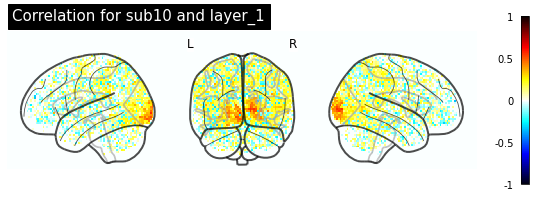

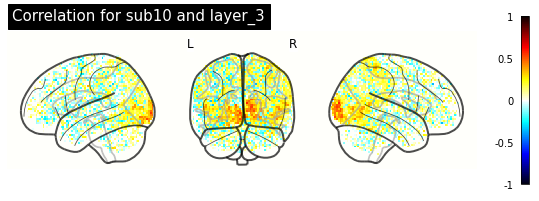

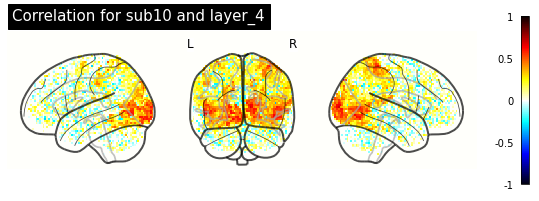

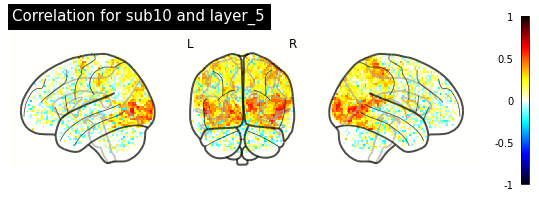

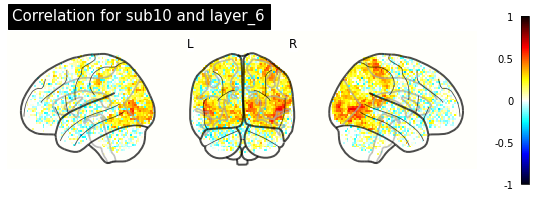

In [ ]:
#Compute correlation coeffients between brain region and layer. This one works to get predictions.
subs=["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"] 
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers=['layer_1','layer_3','layer_4','layer_5', 'layer_6']

data=[]
for sub in subs:
  for ROI in ROIs:
    for layer in layers:
      fmri_dir = '/content/participants_data_v2021'
      prediction_dir = '/content/prediction'
      model = model

      if ROI == "WB":
          track = "full_track"
      else:
          track = "mini_track"

      results_dir = os.path.join(prediction_dir,'model', layer,\
                                track, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      ROI,sub,layer,coefs=perform_encoding(activations_dir, fmri_dir,\
                                      results_dir, sub, layer, ROI=ROI)  
      data.append([ROI,sub,layer,coefs.mean()])

In [ ]:
#Create plots

In [ ]:
#@title predict fMRI responses to test videos for all subjs all ROIS
# will want to try this later. Does not work.
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layers=['layer_1','layer_3','layer_4','layer_5', 'layer_6']
model = 'ResNet'
for sub in subs:
  for ROI in ROIs:
    for layer in layers:
      if ROI == "WB":
          track = "full_track"
      else:
          track = "mini_track"
      results_dir = os.path.join(prediction_dir,'model', layer,\
                            track, sub)
      if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      print ("Starting ROI: ", ROI, "sub: ",sub)
      perform_encoding(activations_dir, fmri_dir,\
                      results_dir, sub, layer,\
                      ROI=ROI,mode='test')
      print ("Completed ROI: ", ROI, "sub: ",sub)
      print("----------------------------------------------------------------------------")

In [ ]:
#@title copied this from alexnet. haven't tried to see if it works.
def get_activations(activations_dir,sub,ROI):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + ROI+'-'+sub + ".npy")
    test_file = os.path.join(activations_dir,"test_" + ROI+'-'+sub + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations
def fmri_encoding(activation_dir, fmri_dir,results_dir, sub, design_ROI,predict_ROI, mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = '/content/activations_alexnet'
  pca_dir = os.path.join(activations_dir,'pca_fmri')
  train_activations,test_activations = get_activations(pca_dir,sub,design_ROI)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,predict_ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,predict_ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = test_activations#train_activations[800:,:]
      train_activations = train_activations[:900,:]
      print(train_activations.shape)
      fmri_train = fmri_train_all[:900,:]
      print(fmri_train.shape)
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 100
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  print(train_activations.shape,test_activations.shape,fmri_train[:,iter:iter+batch_size].shape)
  #pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  reg = OLS_pytorch(use_gpu)
  reg.fit(train_activations,fmri_train.T)
  pred_fmri = reg.predict(test_activations)
  if mode == 'val':
    print(fmri_test.shape,pred_fmri.shape)
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation predicting ROI : ",predict_ROI, "in ",sub," using ROI ",design_ROI, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################

  np.save(pred_fmri_save_path, pred_fmri)
  return (design_ROI,predict_ROI,sub,score)

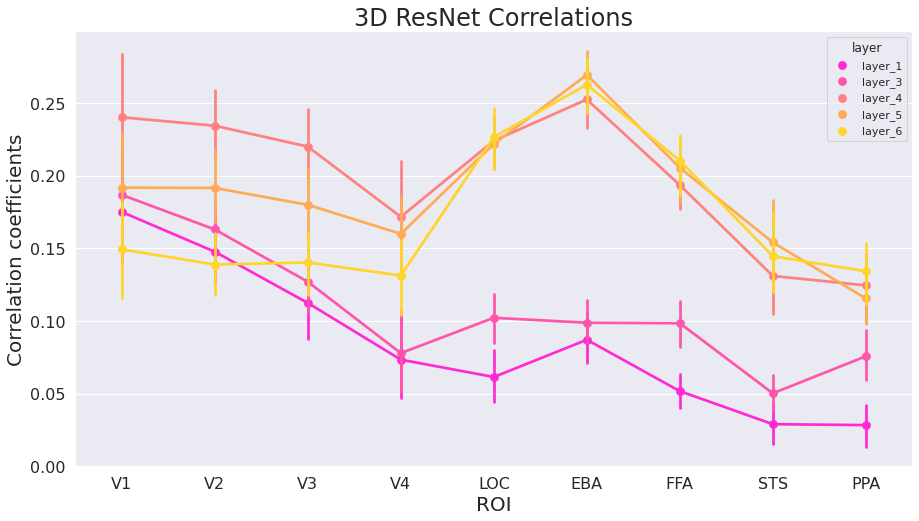

In [ ]:
#@title Plotting function
#pretty plot, also plots by subject
import pandas as pd
import seaborn as sns
ROI_plot = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
plt_df=pd.DataFrame(data=data,columns=['ROI_plot','sub','layer','coefs'])
plt_df.head()
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.pointplot(x='ROI_plot',y='coefs', hue='layer',data=plt_df[plt_df['ROI_plot'].isin(ROI_plot)],
              fontsize =24,palette='spring')
p.set_xlabel("ROI", fontsize = 20)
p.set_ylabel("Correlation coefficients", fontsize = 20)
p.set_title("3D ResNet Correlations", fontsize = 24)
p.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(labels=["Layer 1","Layer 3", "Layer 4", "Layer 5", "Layer 6"], fontsize = 20)
plt.show()

In [ ]:
display(plt_df.head())

ROI_plot    sub    layer     coefs
0       WB  sub01  layer_1  0.022887
1       WB  sub01  layer_3  0.041426
2       WB  sub01  layer_4  0.102775
3       WB  sub01  layer_5  0.097566
4       WB  sub01  layer_6  0.088945

In [ ]:
#@title boring plot
import pandas as pd
import seaborn as sns
plt_df=pd.DataFrame(data=data,columns=['ROI','sub','layer','coefs'])
plt_df.head()
sns.set(rc = {'figure.figsize':(15,8)})
sns.pointplot(x='ROI',y='coefs',hue='layer',data=plt_df)

In [ ]:
#@title heat map
from pandas.core.frame import DataFrame
# Make heatmap 
import pandas as pd
import seaborn as sns

data_prediction=np.load('./prediction/model/layer_5/mini_track/sub07/V4_val.npy')
df = pd.DataFrame(data=data_prediction)
sns.heatmap(df,cmap='viridis')

Misc. Functions: exploring, google drive mounting, zipping files

In [ ]:
#@title mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title explore files

#format data as pandas dataframe

#test=np.load('prediction/alexnet/layer_5/mini_track/sub07/V1_test.npy')
#test.shape # dim1=test videos (fixed n - hold out set) , dim2=voxels

#with open('participants_data_v2021/mini_track/sub10/V2.pk1') as f:
#  pickle._Unpickler(f)

load_dict('participants_data_v2021/mini_track/sub10/V2.pkl') #train, test

#test2=pickle._Unpickler('participants_data_v2021/mini_track/sub10/V2.pk1')

In [ ]:
#@title Look at files in directory
#os.listdir('prediction/alexnet/layer_5/mini_track/sub07/')
os.listdir('./participants_data_v2021/full_track/sub03/WB.pkl')
#os.listdir('participants_data_v2021/mini_track/sub10/')

In [ ]:
#@title zip files
import zipfile

list_files = glob.glob(activations_dir +'/*'+layer+'.npy')

with zipfile.ZipFile('final.zip', 'w') as zipF:
    for file in list_files:
        zipF.write(file, compress_type=zipfile.ZIP_DEFLATED)

print('The files has been compressed')

# Reference

Cichy et al., The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. arXiv 2021. arXiv: [2104.13714v1](https://arxiv.org/abs/2104.13714v1)


